In [5]:
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
eps = np.finfo(float).eps

import tqdm

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline
sns.set()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()

In [7]:
def load_data(path):
    with np.load(path) as f:
        x_train = f['train_data']
        x_valid = f['valid_data']
        x_test = f['test_data']
        return x_train, x_valid, x_test

In [8]:
def loss_bcel(x, x_hat):
    BCEL = F.binary_cross_entropy_with_logits(
        x_hat.view(-1, 1), x.view(-1, 1), reduction='mean')
    return BCEL


def loss_bce(x, x_hat):
    BCE = F.binary_cross_entropy(
        x_hat.view(-1, 1), x.view(-1, 1), reduction='mean')
    return BCE


def train_validate(model, dataloader, optim, loss_fn, train):
    model.train() if train else model.eval()
    total_loss = 0
    for batch_idx, x in enumerate(dataloader):
        x = x[0]
        x_hat = model(x)
        loss = loss_fn(x, x_hat)

        if train:
            optim.zero_grad()
            loss.backward()
            optim.step()

        total_loss += loss.item()
    return total_loss / len(dataloader.dataset)


def init_weights(module):
    for m in module.modules():
        if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
            init.xavier_normal_(m.weight.data)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias, 0.0)
        elif isinstance(m, nn.Sequential):
            for sub_mod in m:
                init_weights(sub_mod)

In [9]:
class MaskedLinear(nn.Linear):
    
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias=bias)
        self.register_buffer('mask', torch.ones([out_features, in_features]))
        self.reset_parameters()

    def forward(self, x):
        return F.linear(x, self.mask * self.weight, self.bias)
    
    def set_mask(self, mask):
        mask = torch.from_numpy(mask.astype(np.uint8).T)
        if not (self.mask.data.size() == mask.size()):
            raise Exception('size mask mismatch')
        self.mask.data.copy_(mask)
        
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.bias is not None:
            init.zeros_(self.bias)


class MADE1(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, shuffle_input=False):
        super(MADE1, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.shuffle_input = shuffle_input
        self.hs = [self.input_size] + self.hidden_sizes + [self.output_size]
        
        self.network = []
        for in_feat, out_feat in zip(self.hs, self.hs[1:]):
            self.network.extend([
                            MaskedLinear(in_feat, out_feat),
                            nn.ReLU(),
                            ])
        self.network.pop()
        self.network = nn.Sequential(*self.network)
        # set all masks
        self.init_masks()
        
    def init_masks(self):
        # Build the masks
        L = len(self.hidden_sizes)
        m = {}
        m[-1] = rng.permutation(self.input_size) if self.shuffle_input else np.arange(self.input_size)
        
        rng = np.random.RandomState(0)
        for l in range(L):
            m[l] = rng.randint(min(m[l - 1]), self.input_size - 1, size=self.hidden_sizes[l])

        # Build W Masks
        masks = []
        for l in range(L):
            W = m[l-1][:, None] <= m[l][None, :]
            masks.append(W)
        # V mask
        V = m[L-1][:, None] < m[-1][None, :]
        masks.append(V)
        
        # copied from karpathy
        if self.output_size > self.input_size:
            k = self.output_size // self.input_size
            # replicate the last mask across the other outputs
            masks[-1] = np.concatenate([masks[-1]]*k, axis=1)

        # Set masks in network
        mask_layers = [l for l in self.network.modules() if isinstance(l, MaskedLinear)]
        for layer, mask in zip(mask_layers, masks):
            layer.set_mask(mask)
        
    def forward(self, x):
        x = self.network(x)
        return F.softmax(x, dim=-1)
        

In [10]:
x_train, x_valid, x_test = load_data('../data/binarized_mnist.npz')

x_train = torch.from_numpy(x_train).cuda() if use_cuda else torch.from_numpy(x_train)
x_valid = torch.from_numpy(x_valid).cuda() if use_cuda else torch.from_numpy(x_valid)
x_test = torch.from_numpy(x_test).cuda() if use_cuda else torch.from_numpy(x_test)


input_size = x_train.size(1)
output_size = x_train.size(1)
hidden_sizes = [784 // 2, 784 // 2, 784 // 8, 784 // 2, 784 // 2]
batch_size = 100

model = MADE1(input_size, hidden_sizes, output_size, False)
model = model.cuda() if use_cuda else model
model.apply(init_weights)

optim = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=45, gamma=0.1)
    
loss_fn = loss_bce
n_epochs = 80

dataloader_train = DataLoader(TensorDataset(x_train), batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(TensorDataset(x_valid), batch_size=batch_size, shuffle=True)

In [11]:
x = dataloader_train.__iter__().__next__()[0]

In [12]:
x.size()

torch.Size([100, 784])

In [ ]:
train_loss = []
val_loss = []
for epoch in tqdm.tqdm_notebook(range(0, n_epochs)):
    scheduler.step(epoch)
    t_loss = train_validate(model, dataloader_train, optim, loss_fn, train=True)
    train_loss.append(t_loss)

    if epoch % 100 == 0:
        v_loss = train_validate(model, dataloader_val, optim, loss_fn, train=False)
        val_loss.append(v_loss)

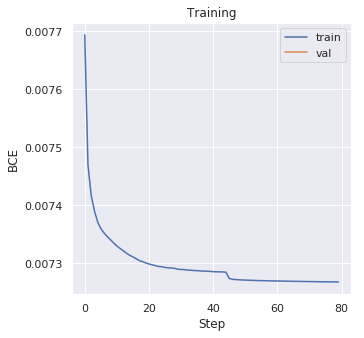

In [12]:
sns.set()
plt.rcParams['figure.figsize'] = 5, 5
plt.plot(np.arange(len(train_loss)), train_loss, label='train')
plt.plot(np.arange(0, len(val_loss) * 100, 100), val_loss, label='val')
plt.title('Training')
plt.xlabel('Step')
plt.ylabel('BCE')
plt.legend()
plt.grid(True)

In [13]:
# Test set reconstruction here
# 
x_test_hat = model(x_test)

In [14]:
ind = np.random.randint(0, x_test_hat.size(0), 10)
im = x_test.cpu().detach().numpy()[ind, :]
im_hat = x_test_hat.cpu().detach().numpy()[ind, :]

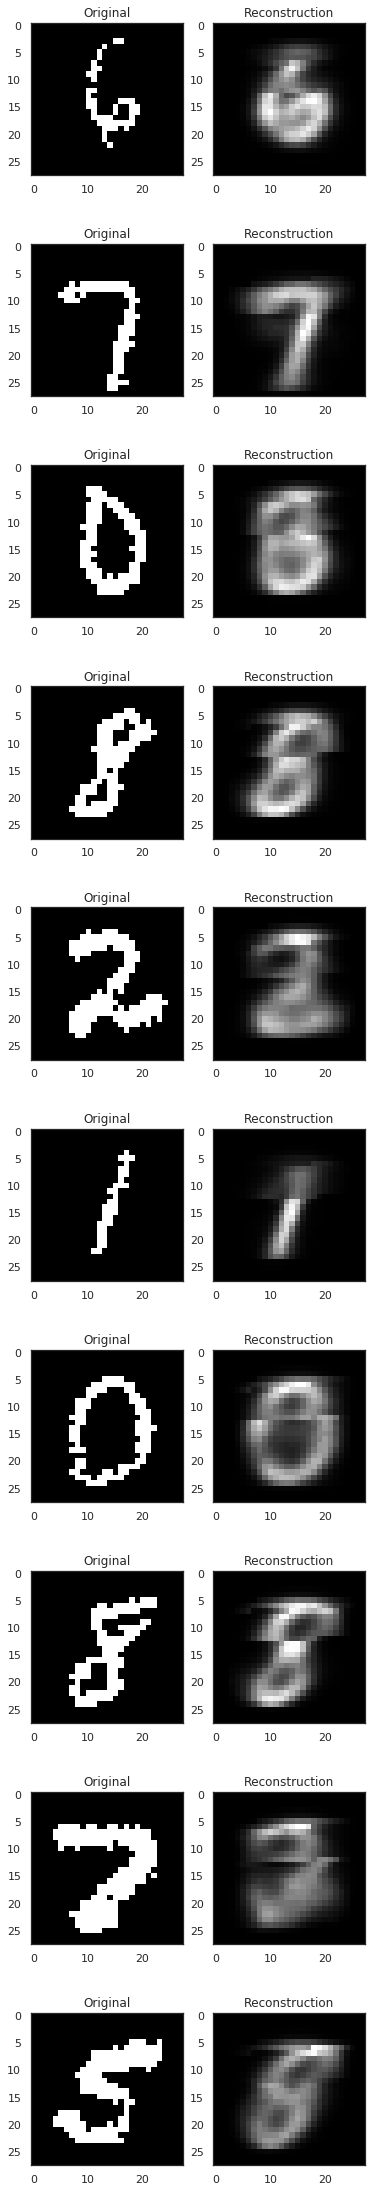

In [15]:
plt.rcParams['figure.figsize'] = 6, 40
with sns.axes_style('white'):
    fig, axis = plt.subplots(nrows=10, ncols=2)
    
    for i in range(10):
    
        axis[i, 0].imshow(im[i].reshape(28, 28), cmap='gray')
        axis[i, 0].set_title('Original')

        axis[i, 1].imshow(im_hat[i].reshape(28, 28), cmap='gray')
        axis[i, 1].set_title('Reconstruction')